In [1]:
#JesseRuiz_Capstoneproject_PredictingRecidivisminDomesticViolence_Phase2

# PLAN - PHASE 2

0. [x] Get the data.
0. [x] Prepare the data for exploration.
0. [ ] Split the data into train and test sets.
0. [ ] Explore the data.
0. [ ] Do cross-validation with the data.
0. [ ] Code and evaluate several models.
0. [ ] Evaluate out of sample data (test set).

# ENVIRONMENT

In [60]:
# basic environment and custom scripts
import os
import acquire
import prepare
import explore
import time

# from prepare import rename_columns
# from prepare import replace_nonvals
# from prepare import value_counts

# numpy and pandas for dataframe building and manipulation
import pandas as pd
import numpy as np
%matplotlib inline

# matplotlib and seaborn for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# import preprocessing for scaling and splitting
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# xgboost for feature selection
import xgboost as xgb

# for tsne plot
from sklearn.manifold import TSNE

# for PCA
from sklearn.decomposition import PCA


# Grid search
from sklearn.model_selection import GridSearchCV

# sklearn machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.model_selection import cross_val_score

#  balanced bagging classifier
from imblearn.ensemble import BalancedBaggingClassifier

from functools import reduce

In [3]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

# PHASE 2 INFORMATION

## During phase 2, we look at a subset of our dataframe (705 cases/respondents) and examine the 497 AW (Abused Woman) cases where there was multiple cases of assault (re-assault).
* The target variable changes from Abuse_past_year to Reassault.
* The focus shifts to analyzing the features that predict that there will be reassault, instead of analyzing when there will be abuse or not.

# ACQUISITION

## Dataframes 6 & 11 contain information on AW (Abused Woman) cases.

In [4]:
dfa, dfb = acquire.get_data()

In [5]:
# dfa is datasets 1, 2, 3, 4, 5, 7. All cases AW and NAW.
dfa.head()

,CASEID,ABUSED,SCRSTATR,LENGTHC1,C1SITUAT,PABUSE,D3RCHILT,E13PRGNT,N7PREGNT,TOTSUPRT,...,N16CHILD,N17ARRST,N1FRQNCY,N2SVRITY,N3WEAPON,N4CHOKE,N5SEX,N6CONTRL,N8JEALUS,N10CPBLE
0,108395,1,1,1,1,1,1,3,2,9,...,2,2,2,2,2,2,2,2,2,2
1,108397,1,1,2,1,1,0,3,3,11,...,2,1,2,1,1,1,1,2,1,1
2,108399,1,1,5,1,1,6,3,2,9,...,2,2,2,2,2,1,2,2,2,2
3,108443,1,1,2,1,1,0,1,2,12,...,2,1,2,2,1,1,2,1,2,2
4,108444,1,1,2,1,1,1,2,2,11,...,2,1,1,1,2,2,2,2,2,2


In [6]:
# dfb is datasets 6 & 11. AW cases only.
dfb.head()

,CASEID,M5FIRED,M11HIGH,M35SAFE,M41ILLGL,M42DAGRR,M13TALKR,M32OTHER,M27HOW,M30ARRES,...,FORCEDR,MISCARR,RESTRAIN,CHOKED,NDRUNK,RDRUNK,BOTHDRUN,NDRUGS,RDRUGS,BOTHDRUG
0,108395,9999,2,1,2,0,1,99,99999,3,...,0,0,0,0,0,0,0,0,0,0
1,108397,9999,2,1,2,0,1,99,99999,3,...,0,0,0,1,2,0,0,0,0,0
2,108399,9999,2,1,2,0,1,99,99999,3,...,0,0,1,1,0,0,0,0,0,0
3,108443,9999,2,1,2,0,1,13,99999,3,...,0,0,0,1,1,0,0,0,0,0
4,108444,9999,1,1,2,0,1,99,99999,3,...,0,0,0,0,3,0,0,0,0,0


# Examine dfb in more detail. Use custom functions from prepare script to take information from df10 and create a column that shows which cases had repeat offenses.

In [7]:
dfb['RECID'] = dfb.CASEID.apply(prepare.get_repeat_case)

In [8]:
dfb.head()

,CASEID,M5FIRED,M11HIGH,M35SAFE,M41ILLGL,M42DAGRR,M13TALKR,M32OTHER,M27HOW,M30ARRES,...,MISCARR,RESTRAIN,CHOKED,NDRUNK,RDRUNK,BOTHDRUN,NDRUGS,RDRUGS,BOTHDRUG,RECID
0,108395,9999,2,1,2,0,1,99,99999,3,...,0,0,0,0,0,0,0,0,0,0
1,108397,9999,2,1,2,0,1,99,99999,3,...,0,0,1,2,0,0,0,0,0,1
2,108399,9999,2,1,2,0,1,99,99999,3,...,0,1,1,0,0,0,0,0,0,1
3,108443,9999,2,1,2,0,1,13,99999,3,...,0,0,1,1,0,0,0,0,0,0
4,108444,9999,1,1,2,0,1,99,99999,3,...,0,0,0,3,0,0,0,0,0,1


# Clean up the dataset for exploration...

In [9]:
dfb.columns

Index(['CASEID', 'M5FIRED', 'M11HIGH', 'M35SAFE', 'M41ILLGL', 'M42DAGRR',
       'M13TALKR', 'M32OTHER', 'M27HOW', 'M30ARRES', 'M31HOW', 'M38ORDER',
       'SEVERER', 'TOTINCR', 'THREATR', 'SLAPR', 'PUNCHR', 'BEATR', 'UWEAPON',
       'FORCEDR', 'MISCARR', 'RESTRAIN', 'CHOKED', 'NDRUNK', 'RDRUNK',
       'BOTHDRUN', 'NDRUGS', 'RDRUGS', 'BOTHDRUG', 'RECID'],
      dtype='object')

In [10]:
dfb = prepare.rename_columns_recid(dfb)

In [11]:
dfb.head()

,id,gun_fired,anyone_high,safe_place,forced_illegal,life_danger,talk_about_it,left_or_not,medical_staff_helpful,perp_arrested_ever,...,miscarriage_resulted,restrained_by_perp,num_choked,num_perp_drunk,num_woman_drunk,num_both_drunk,num_perp_drugs,num_woman_drugs,num_both_drugs,reassault
0,108395,9999,2,1,2,0,1,99,99999,3,...,0,0,0,0,0,0,0,0,0,0
1,108397,9999,2,1,2,0,1,99,99999,3,...,0,0,1,2,0,0,0,0,0,1
2,108399,9999,2,1,2,0,1,99,99999,3,...,0,1,1,0,0,0,0,0,0,1
3,108443,9999,2,1,2,0,1,13,99999,3,...,0,0,1,1,0,0,0,0,0,0
4,108444,9999,1,1,2,0,1,99,99999,3,...,0,0,0,3,0,0,0,0,0,1


In [12]:
prepare.value_counts(dfb)

# for col in dfb.columns:
# #         n = dfb[col].unique().shape[0]
# #         col_bins = min(n, 10)
#         print(f'{col}:')
#         if dfb[col].dtype in ['int64', 'float64']:
#             print(dfb[col].value_counts(sort=False, dropna=False))
#         else:
#             print(dfb[col].value_counts(dropna=False))
#         print('\n')

id

-------------------------------------------------------------

gun_fired
1        10
2        41
9999    444
999       2
Name: gun_fired, dtype: int64

-------------------------------------------------------------

anyone_high
1      101
2      389
888      2
999      5
Name: anyone_high, dtype: int64

-------------------------------------------------------------

safe_place
1      391
2       97
999      9
Name: safe_place, dtype: int64

-------------------------------------------------------------

forced_illegal
1       86
2      402
999      9
Name: forced_illegal, dtype: int64

-------------------------------------------------------------

life_danger
0      240
1      249
999      8
Name: life_danger, dtype: int64

-------------------------------------------------------------

talk_about_it
1      352
2      140
999      5
Name: talk_about_it, dtype: int64

-------------------------------------------------------------

left_or_not
(10.911000000000001, 19.8]    125
(19.8, 28.6

In [13]:
prepare.replace_nonvals_recid(dfb)

In [14]:
dfb.head()

,id,gun_fired,anyone_high,safe_place,forced_illegal,life_danger,talk_about_it,left_or_not,medical_staff_helpful,perp_arrested_ever,...,miscarriage_resulted,restrained_by_perp,num_choked,num_perp_drunk,num_woman_drunk,num_both_drunk,num_perp_drugs,num_woman_drugs,num_both_drugs,reassault
0,108395,0,0,1,0,0,1,0,0,3,...,0,0,0,0,0,0,0,0,0,0
1,108397,0,0,1,0,0,1,0,0,3,...,0,0,1,2,0,0,0,0,0,1
2,108399,0,0,1,0,0,1,0,0,3,...,0,1,1,0,0,0,0,0,0,1
3,108443,0,0,1,0,0,1,1,0,3,...,0,0,1,1,0,0,0,0,0,0
4,108444,0,1,1,0,0,1,0,0,3,...,0,0,0,3,0,0,0,0,0,1


In [15]:
# Check the value counts of the columns to make sure the function worked
prepare.value_counts(dfb)

id

-------------------------------------------------------------

gun_fired
0    487
1     10
Name: gun_fired, dtype: int64

-------------------------------------------------------------

anyone_high
0    396
1    101
Name: anyone_high, dtype: int64

-------------------------------------------------------------

safe_place
0    106
1    391
Name: safe_place, dtype: int64

-------------------------------------------------------------

forced_illegal
0    411
1     86
Name: forced_illegal, dtype: int64

-------------------------------------------------------------

life_danger
0    248
1    249
Name: life_danger, dtype: int64

-------------------------------------------------------------

talk_about_it
0    145
1    352
Name: talk_about_it, dtype: int64

-------------------------------------------------------------

left_or_not
0    372
1    125
Name: left_or_not, dtype: int64

-------------------------------------------------------------

medical_staff_helpful
0     451
11      7
21   

# Prepare dfa to merge it with the dfb

In [16]:
dfa.columns

Index(['CASEID', 'ABUSED', 'SCRSTATR', 'LENGTHC1', 'C1SITUAT', 'PABUSE',
       'D3RCHILT', 'E13PRGNT', 'N7PREGNT', 'TOTSUPRT', 'G1NUMBER', 'H1JEALUS',
       'H2LIMIT', 'H3KNOWNG', 'J1HIT', 'J2THROWN', 'J3PUSH', 'J4SLAP',
       'J5KICK', 'J6OBJECT', 'J7BEAT', 'J8CHOKE', 'J9KNIFE', 'J10GUN',
       'J11SEX', 'POWER', 'HARASS', 'B1AGE', 'AGEDISP', 'STDETAI', 'SAMESEXR',
       'N11DRUGS', 'N12ALCHL', 'N13SUHIM', 'N16CHILD', 'N17ARRST', 'N1FRQNCY',
       'N2SVRITY', 'N3WEAPON', 'N4CHOKE', 'N5SEX', 'N6CONTRL', 'N8JEALUS',
       'N10CPBLE'],
      dtype='object')

In [17]:
#use prepare function to rename features 
dfa = prepare.rename_columns_all(dfa)

In [18]:
# use prepare function to re-encode data
prepare.replace_nonvals_all(dfa)

In [19]:
dfa.head()

,id,abuse_past_year,abuse_status,length_relationship,partner_abusive,num_abusers,num_children,pregnant,beaten_while_pregnant,support_score,...,partner_reported_child_abuse,partner_arrested,violence_increased,severity_increased,weapon_ever,choked_ever,rape_ever,controlled_ever,jealous,capable_murder
0,108395,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,108397,1,1,2,1,1,0,0,0,11,...,0,1,0,1,1,1,1,0,1,1
2,108399,1,1,5,1,1,2,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,108443,1,1,2,1,1,0,1,0,12,...,0,1,0,0,1,1,0,1,0,0
4,108444,1,1,2,1,1,1,0,0,11,...,0,1,1,1,0,0,0,0,0,0


In [20]:
dfa.columns

Index(['id', 'abuse_past_year', 'abuse_status', 'length_relationship',
       'partner_abusive', 'num_abusers', 'num_children', 'pregnant',
       'beaten_while_pregnant', 'support_score', 'guns_in_home',
       'jealous_past_year', 'limit_family_contact', 'location_tracking',
       'threat_hit', 'threat_object', 'push_shove', 'slap', 'kick_punch',
       'hit_object', 'beaten', 'choked', 'threat_knife', 'threat_gun',
       'rape_with_threat', 'power_scale', 'harass_scale', 'id_age',
       'age_disparity', 'children_not_partner', 'same_sex_relationship',
       'partner_drug_use', 'partner_alcohol_use', 'threat_suicide',
       'partner_reported_child_abuse', 'partner_arrested',
       'violence_increased', 'severity_increased', 'weapon_ever',
       'choked_ever', 'rape_ever', 'controlled_ever', 'jealous',
       'capable_murder'],
      dtype='object')

In [21]:
prepare.merge_all_recid(dfa, dfb)

,id,abuse_past_year,abuse_status,length_relationship,partner_abusive,num_abusers,num_children,pregnant,beaten_while_pregnant,support_score,...,miscarriage_resulted,restrained_by_perp,num_choked,num_perp_drunk,num_woman_drunk,num_both_drunk,num_perp_drugs,num_woman_drugs,num_both_drugs,reassault
0,108395,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,108397,1,1,2,1,1,0,0,0,11,...,0,0,1,2,0,0,0,0,0,1
2,108399,1,1,5,1,1,2,0,0,0,...,0,1,1,0,0,0,0,0,0,1
3,108443,1,1,2,1,1,0,1,0,12,...,0,0,1,1,0,0,0,0,0,0
4,108444,1,1,2,1,1,1,0,0,11,...,0,0,0,3,0,0,0,0,0,1
5,108456,1,1,2,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,108460,1,1,3,1,1,1,0,1,10,...,0,0,0,0,0,0,0,0,0,1
7,108525,1,1,4,1,2,2,0,0,11,...,0,0,0,0,0,0,0,0,0,1
8,108562,1,1,5,1,1,2,0,0,11,...,0,0,0,2,0,0,0,0,0,1
9,118051,1,0,6,1,1,2,0,0,10,...,0,0,0,0,0,0,0,0,0,0


In [22]:
df = prepare.merge_all_recid(dfa, dfb)

In [23]:
df.head()

,id,abuse_past_year,abuse_status,length_relationship,partner_abusive,num_abusers,num_children,pregnant,beaten_while_pregnant,support_score,...,miscarriage_resulted,restrained_by_perp,num_choked,num_perp_drunk,num_woman_drunk,num_both_drunk,num_perp_drugs,num_woman_drugs,num_both_drugs,reassault
0,108395,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,108397,1,1,2,1,1,0,0,0,11,...,0,0,1,2,0,0,0,0,0,1
2,108399,1,1,5,1,1,2,0,0,0,...,0,1,1,0,0,0,0,0,0,1
3,108443,1,1,2,1,1,0,1,0,12,...,0,0,1,1,0,0,0,0,0,0
4,108444,1,1,2,1,1,1,0,0,11,...,0,0,0,3,0,0,0,0,0,1


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497 entries, 0 to 496
Data columns (total 73 columns):
id                              497 non-null int64
abuse_past_year                 497 non-null int64
abuse_status                    497 non-null int64
length_relationship             497 non-null int64
partner_abusive                 497 non-null int64
num_abusers                     497 non-null int64
num_children                    497 non-null int64
pregnant                        497 non-null int64
beaten_while_pregnant           497 non-null int64
support_score                   497 non-null int64
guns_in_home                    497 non-null int64
jealous_past_year               497 non-null int64
limit_family_contact            497 non-null int64
location_tracking               497 non-null int64
threat_hit                      497 non-null int64
threat_object                   497 non-null int64
push_shove                      497 non-null int64
slap                        

# Check for nulls

In [25]:
# Check for nulls
prepare.get_nulls_by_column(dfb)

Empty DataFrame
Columns: [sum_nulls, nulls_by_percent]
Index: []


In [26]:
prepare.get_nulls_by_row(dfb)

# No nulls found

In [27]:
prepare.get_nulls_by_column(df)

Empty DataFrame
Columns: [sum_nulls, nulls_by_percent]
Index: []


In [28]:
prepare.get_nulls_by_row(df)

# No nulls found

In [29]:
df.columns

Index(['id', 'abuse_past_year', 'abuse_status', 'length_relationship',
       'partner_abusive', 'num_abusers', 'num_children', 'pregnant',
       'beaten_while_pregnant', 'support_score', 'guns_in_home',
       'jealous_past_year', 'limit_family_contact', 'location_tracking',
       'threat_hit', 'threat_object', 'push_shove', 'slap', 'kick_punch',
       'hit_object', 'beaten', 'choked', 'threat_knife', 'threat_gun',
       'rape_with_threat', 'power_scale', 'harass_scale', 'id_age',
       'age_disparity', 'children_not_partner', 'same_sex_relationship',
       'partner_drug_use', 'partner_alcohol_use', 'threat_suicide',
       'partner_reported_child_abuse', 'partner_arrested',
       'violence_increased', 'severity_increased', 'weapon_ever',
       'choked_ever', 'rape_ever', 'controlled_ever', 'jealous',
       'capable_murder', 'gun_fired', 'anyone_high', 'safe_place',
       'forced_illegal', 'life_danger', 'talk_about_it', 'left_or_not',
       'medical_staff_helpful', 'perp_a

In [30]:
len(list(df.columns))

73

# For padding the data to make it balanced, double the non-reassault cases.

In [31]:
# isolate single abuse cases into 
single_abuse = df[df.reassault == 0]

In [32]:
# create new dataframe of just single abuse cases, reassign them new range of case ids
single_abuse['id'] = range(999999, 999999 + len(single_abuse))

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [33]:
#append the padded single assault values to our greater dataframe
df = df.append(single_abuse)

In [34]:
# formally check that there are no nulls in dataframe
prepare.get_nulls_by_column(df)

Empty DataFrame
Columns: [sum_nulls, nulls_by_percent]
Index: []


In [35]:
# check no 2
if not prepare.get_nulls_by_row(df):
    print('no nulls!')
else:
    prepare.get_nulls_by_row(df)

no nulls!


In [36]:
df.shape

(644, 73)

In [37]:
df.reassault.value_counts()

1    350
0    294
Name: reassault, dtype: int64

# Make sure to drop the target variables

In [38]:
# create list of features
features = [col for col in df]
# drop features from this list that are perceived as primary key or target variable
features.remove('id')
features.remove('abuse_past_year')
features.remove('abuse_status')
features.remove('reassault')

In [39]:
features

['length_relationship',
 'partner_abusive',
 'num_abusers',
 'num_children',
 'pregnant',
 'beaten_while_pregnant',
 'support_score',
 'guns_in_home',
 'jealous_past_year',
 'limit_family_contact',
 'location_tracking',
 'threat_hit',
 'threat_object',
 'push_shove',
 'slap',
 'kick_punch',
 'hit_object',
 'beaten',
 'choked',
 'threat_knife',
 'threat_gun',
 'rape_with_threat',
 'power_scale',
 'harass_scale',
 'id_age',
 'age_disparity',
 'children_not_partner',
 'same_sex_relationship',
 'partner_drug_use',
 'partner_alcohol_use',
 'threat_suicide',
 'partner_reported_child_abuse',
 'partner_arrested',
 'violence_increased',
 'severity_increased',
 'weapon_ever',
 'choked_ever',
 'rape_ever',
 'controlled_ever',
 'jealous',
 'capable_murder',
 'gun_fired',
 'anyone_high',
 'safe_place',
 'forced_illegal',
 'life_danger',
 'talk_about_it',
 'left_or_not',
 'medical_staff_helpful',
 'perp_arrested_ever',
 'police_resp',
 'order_protection',
 'level_severity',
 'num_incidents',
 'num_t

# Train/Test Split

In [40]:
# split train and test
X = df[features]
y = df[['reassault']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .15, random_state = 0, stratify=y)

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

# EXPLORATION

## We will run chi-squared tests on our categorical variables in order to get a grasp of importance

In [41]:
# we will run chi-squared tests on our categorical variables in order to get a grasp of importance
sig_feats, sig_dict = explore.get_chi_squared(train_df, features, 'reassault')

length_relationship
Dependent (reject H0)
-----------------------
num_abusers
Dependent (reject H0)
-----------------------
beaten_while_pregnant
Dependent (reject H0)
-----------------------
support_score
Dependent (reject H0)
-----------------------
jealous_past_year
Dependent (reject H0)
-----------------------
limit_family_contact
Dependent (reject H0)
-----------------------
location_tracking
Dependent (reject H0)
-----------------------
threat_hit
Dependent (reject H0)
-----------------------
threat_object
Dependent (reject H0)
-----------------------
push_shove
Dependent (reject H0)
-----------------------
slap
Dependent (reject H0)
-----------------------
kick_punch
Dependent (reject H0)
-----------------------
hit_object
Dependent (reject H0)
-----------------------
beaten
Dependent (reject H0)
-----------------------
choked
Dependent (reject H0)
-----------------------
threat_knife
Dependent (reject H0)
-----------------------
threat_gun
Dependent (reject H0)
----------------

In [42]:
# scale continuous variables
scaler = MinMaxScaler()

scaler.fit(train_df[['id_age']])

train_df[['id_age']] = scaler.transform(train_df[['id_age']])
test_df[['id_age']] = scaler.transform(test_df[['id_age']])

In [43]:
continuous_vars = ['id_age']

In [44]:
sig_feats_c, sig_dict_c = explore.get_significant_t_tests(train_df, ['id_age'], 'reassault')

In [45]:
# call function that combines significant features from dictionaries created in statistical tests if both generated results
# otherwise make list of features just from whichever (t test or chi squared) produced significant results
if sig_feats_c and sig_feats:
    features = explore.combine_significants(sig_dict, sig_dict_c)
elif sig_feats_c:
    features = [item[0] for item in explore.sort_sigs(sig_dict_c)]
elif sig_feats:
    features = [item[0] for item in explore.sort_sigs(sig_dict)]

In [46]:
train_df.head()

,length_relationship,partner_abusive,num_abusers,num_children,pregnant,beaten_while_pregnant,support_score,guns_in_home,jealous_past_year,limit_family_contact,...,miscarriage_resulted,restrained_by_perp,num_choked,num_perp_drunk,num_woman_drunk,num_both_drunk,num_perp_drugs,num_woman_drugs,num_both_drugs,reassault
243,1,1,1,0,0,0,11,0,1,1,...,0,0,99,1,1,1,2,2,2,1
124,4,0,2,0,0,1,10,0,1,1,...,0,0,99,0,0,0,2,2,2,1
299,1,1,1,2,0,0,12,0,1,0,...,0,0,0,0,0,0,0,0,0,0
76,3,1,1,1,0,0,12,0,1,0,...,0,0,0,0,0,0,0,0,0,1
448,5,1,1,1,0,0,6,0,1,1,...,0,0,1,10,0,0,0,0,0,1


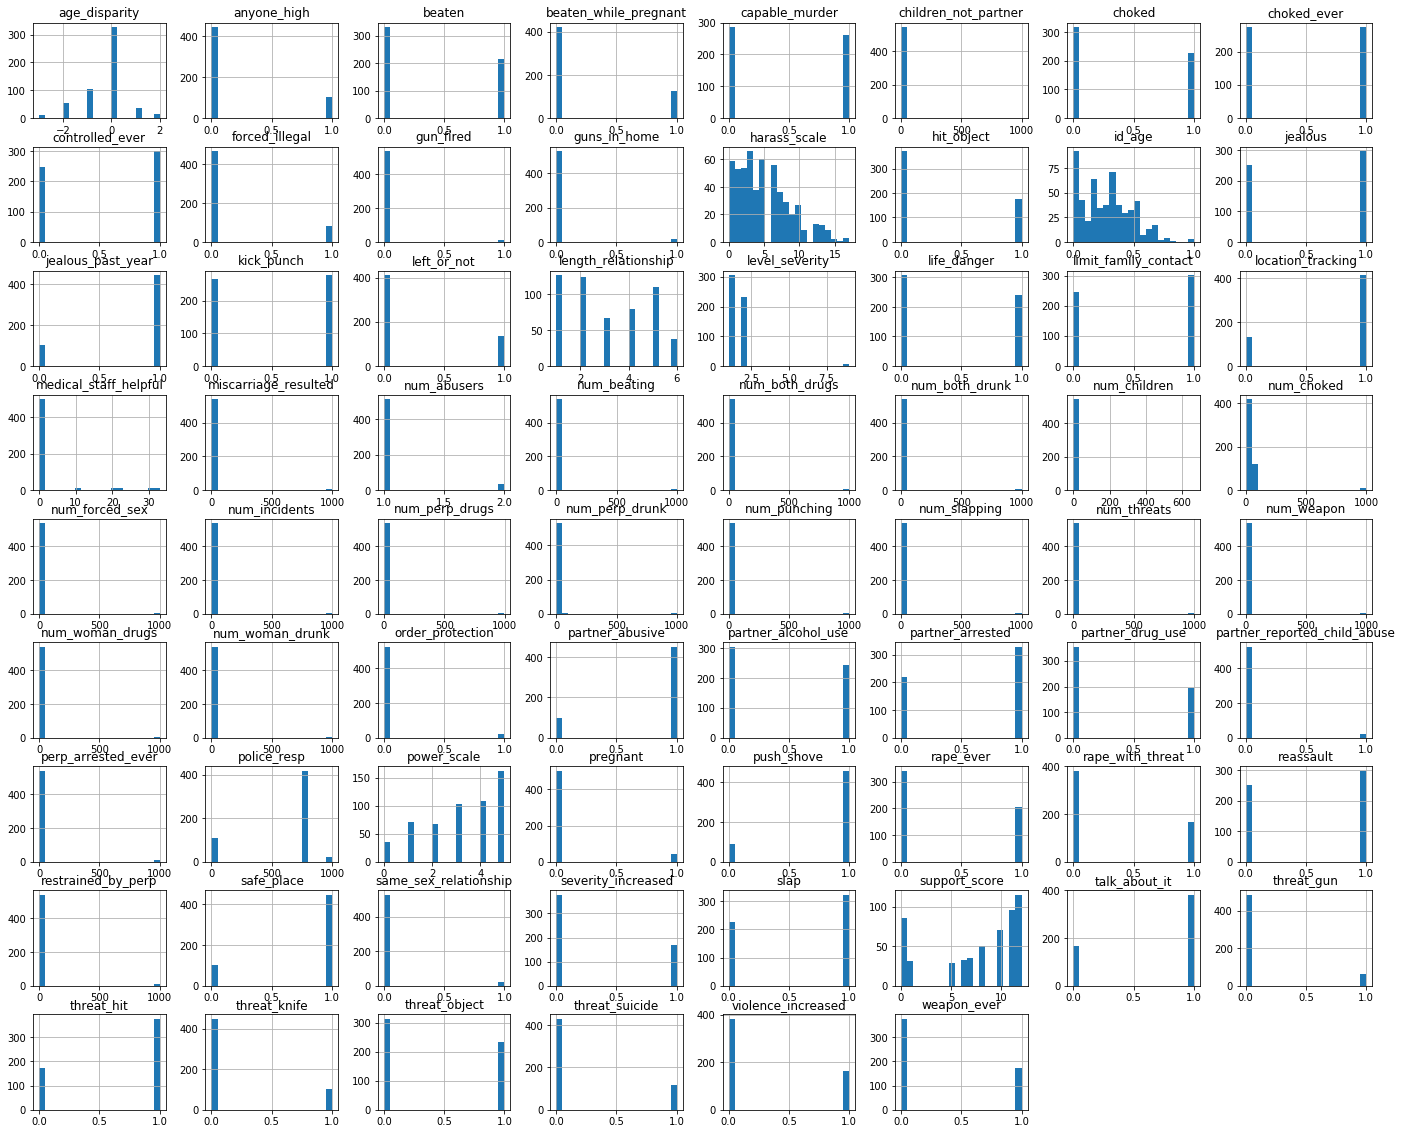

In [49]:
explore.plot_hist(train_df)

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


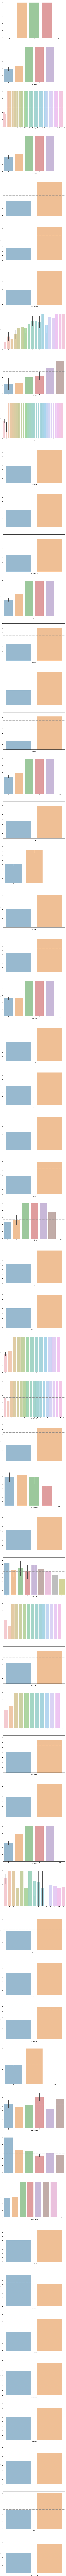

In [51]:
explore.make_bars(train_df, 'reassault', features)

# TSNE PLOT

# t-Distributed Stochastic Neighbor Embedding (t-SNE)

In [56]:
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 0
time_start = time.time()

fashion_tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=250, method='exact')
tsne_results = fashion_tsne.fit_transform(train_df)

print(('t-SNE done! Time elapsed: {} seconds').format(time.time()-time_start))

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 547 / 547
[t-SNE] Mean sigma: 3.550645
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.052218
[t-SNE] Error after 251 iterations: 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464234321326889464182768467546703537516986049910576551282076245490090389328944075868508455133942304583236903222948165808559332123348274797826204144723168738177180919299881250404026184124858368.000000
t-SNE done! Time elapsed: 6.008435964584351 seconds


In [58]:
# Label to color dict (manual)
label_color_dict = {1:'Abuse',0:'Not Abuse'}

# Color vector creation
cvec = [label_color_dict[label] for label in y_train.reassault]

# Plot t-sne

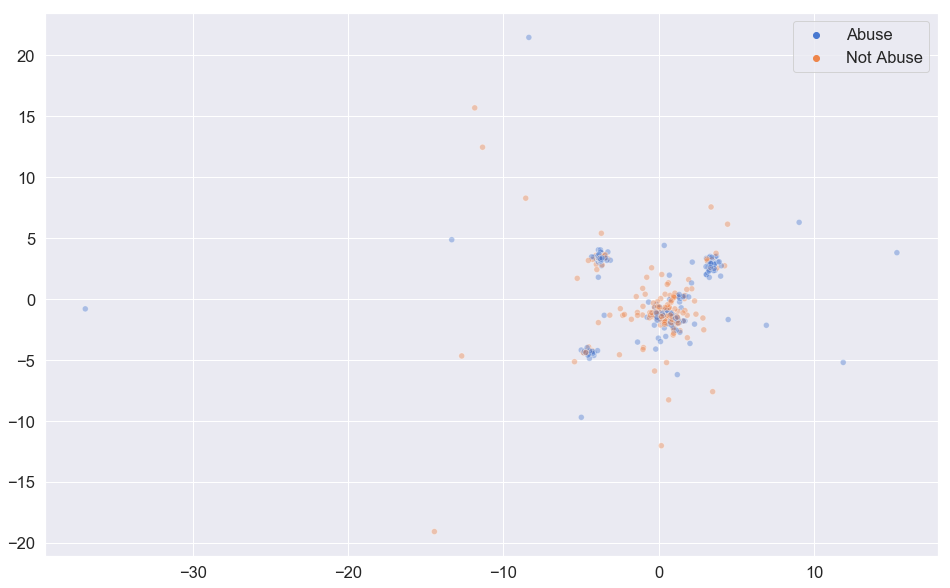

In [59]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=cvec,
    data=train_df,
    legend="full",
    alpha=0.4
)

# This is the (Principal Component Analysis) PCA.

In [61]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(train_df.values)
pca_df = pd.DataFrame()
pca_df['pca-one'] = pca_result[:,0]
pca_df['pca-two'] = pca_result[:,1] 
pca_df['pca-three'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.67533757 0.27403437 0.03167584]


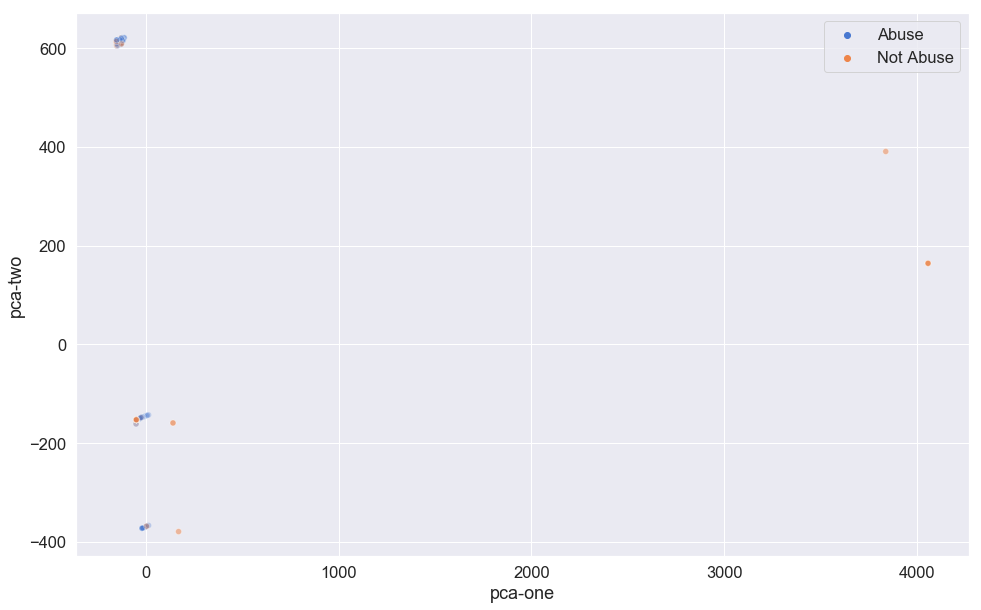

In [62]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=pca_df['pca-one'], y=pca_df['pca-two'],
    hue=cvec,
    data=train_df,
    legend="full",
    alpha=0.3
)

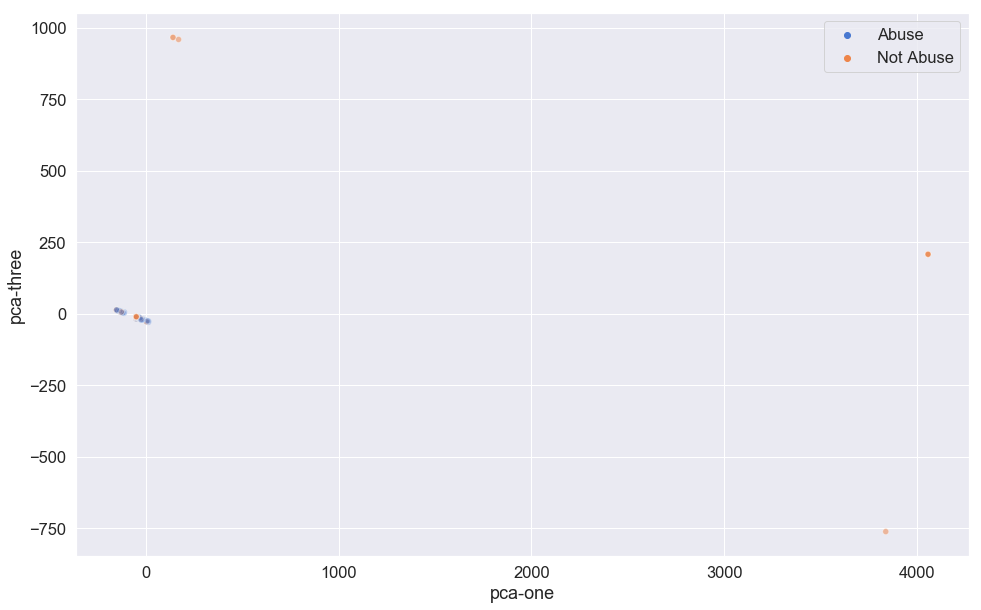

In [63]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=pca_df['pca-one'], y=pca_df['pca-three'],
    hue=cvec,
    data=train_df,
    legend="full",
    alpha=0.3
)

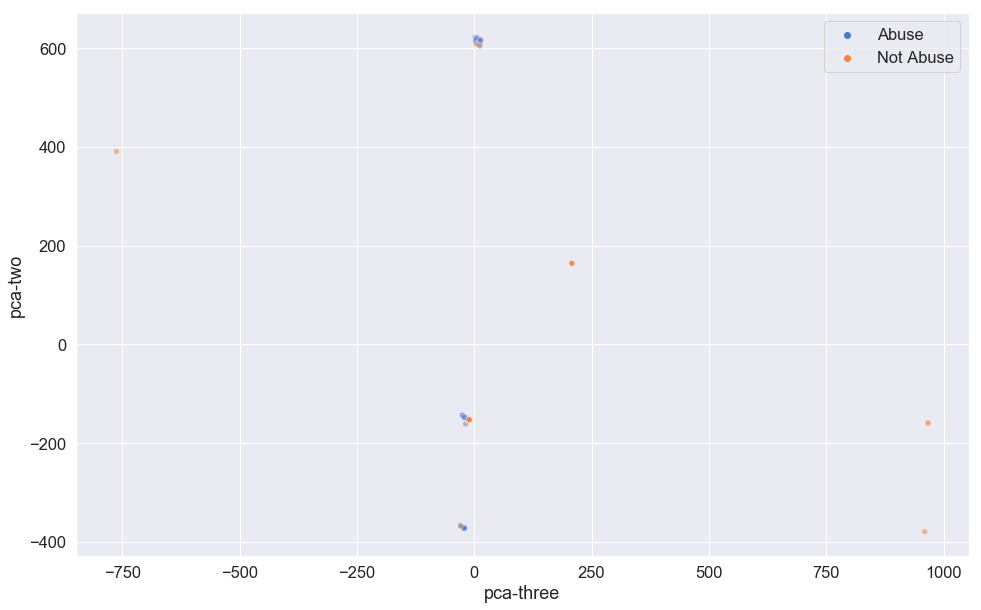

In [64]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=pca_df['pca-three'], y=pca_df['pca-two'],
    hue=cvec,
    data=train_df,
    legend="full",
    alpha=0.3
)

# Bokeh Plots
### See for more information: https://programminghistorian.org/en/lessons/visualizing-with-bokeh#what-is-bokeh

In [265]:
# Jitter plot
# # Import the necessary modules
# from bokeh.plotting import figure, output_file, show, output_notebook
# from bokeh.models import ColumnDataSource
# from bokeh.io import show, output_file
# from bokeh.transform import jitter

# # Construct the interactive tools
# TOOLS = "crosshair,pan,wheel_zoom,box_zoom,reset,box_select,lasso_select"

# # Format the data for the bokeh plot to use
# source = ColumnDataSource(dfa)

# # establish a y value for the not abused and then a y value for the abused
# y_range=dfa.power_scale

# # Construct the figure
# p = figure(plot_width=800, plot_height=300, y_range=['Under 20', 'Between 21-30', 'Over 30'], x_axis_type='linear',
#            title="Harass Scale with Abused and Not Abused Women")

# # p = Scatter(dfa, x='abuse_last_year', y='id_age', color="reassault", title="Abuse vs Age and Reassault",
# #             xlabel="Abuse", ylabel="Age")

# p.circle(x='harass_scale', y=jitter('power_scale', width=0.6, range=p.y_range),  source=dfa, alpha=0.3, fill_color='abuse_past_year')

# # add a circle renderer with vectorized colors and sizes
# # p.circle(dfa.abuse_past_year, dfa.id_age, fill_color='navy', fill_alpha=0.6, line_color=None)

# # show the results
# show(p)

# # Create axis titles
# p.xaxis.axis_label = 'Harass Scale'
# p.yaxis.axis_label = 'Power Scale'


# # Output the file 
# # output_file('abusevsnotabuse.html')

In [263]:
import pandas as pd
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource
from bokeh.models.tools import HoverTool

from bokeh.palettes import Spectral5
from bokeh.transform import factor_cmap

In [294]:
grouped = dfa.groupby('abuse_past_year')['id_age', 'harass_scale', 'power_scale', 'length_relationship'].mean()
grouped

,id_age,harass_scale,power_scale,length_relationship
abuse_past_year,,,,
0,32.543269,0.875000,1.024038,3.322115
1,30.722334,5.472837,3.448692,3.070423


In [302]:
grouped.rename(index = {0: "not_abused", 
                     1:"abused"}, inplace = True) 

In [311]:
grouped

,id_age,harass_scale,power_scale,length_relationship
abuse_past_year,,,,
not_abused,32.543269,0.875000,1.024038,3.322115
abused,30.722334,5.472837,3.448692,3.070423


In [312]:
dfa.groupby(['abuse_past_year', 'same_sex_relationship'])['id_age', 'harass_scale', 'power_scale', 'length_relationship'].mean()

id_age  harass_scale  power_scale  \
abuse_past_year same_sex_relationship                                         
0               0                      32.478261      0.859903     1.014493   
                1                      46.000000      4.000000     3.000000   
1               0                      30.728601      5.436326     3.436326   
                1                      30.555556      6.444444     3.777778   

                                       length_relationship  
abuse_past_year same_sex_relationship                       
0               0                                 3.328502  
                1                                 2.000000  
1               0                                 3.098121  
                1                                 2.333333

In [313]:
# Colored bar chart
output_file('harass.html')

# establish the categories to plot
source = ColumnDataSource(grouped)

In [314]:
abuse_stat = list(np.unique(source.data['abuse_past_year']))
p = figure(x_range=abuse_stat)

In [315]:
abuse_stat

['abused', 'not_abused']

In [319]:
color_map = factor_cmap(field_name='abuse_past_year',
                    palette=Spectral5, factors=abuse_stat)
p.vbar(x='abuse_past_year', top='id_age', source=source, width=0.70, color=color_map)
p.title.text ='Average Age by Abuse Status'
p.xaxis.axis_label = 'Abused or Not Abused'
p.yaxis.axis_label = 'Average Age'

# adds the hover tool
hover = HoverTool()
hover.tooltips = [
    ("Averages", "@harass_scale Harass Scale / @power_scale Power Scale / @length_relationship Length of Relationship")]

hover.mode = 'vline'

p.add_tools(hover)

show(p)

In [317]:
output_notebook()

Loading BokehJS ...

# PREPARATION

In [ ]:
# function to remove any "significant features" that automatically denote target
prepare.remove_phase_2_features(features)

In [ ]:
# create some subsets of significant features to assess model performance
top_5 = features[0:5]
top_10 = features[0:10]
top_15 = features[0:15]

# MODELING

# Naive Bayes

In [36]:
import model
gnb_model, y_pred, y_pred_proba = model.naive_bayes(features, X_train, y_train)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [37]:
print('Accuracy of GNB classifier on training set: {:.2f}'
     .format(gnb_model.score(X_train[features], y_train)))

Accuracy of GNB classifier on training set: 0.70


In [38]:
# print raw confusion matrix:
# ~~~~~ edit this to display cleaner ~~~~~
print(confusion_matrix(y_train, y_pred))

[[101 149]
 [ 15 282]]


In [39]:
# classification report
print(classification_report(y_train, y_pred))


              precision    recall  f1-score   support

           0       0.87      0.40      0.55       250
           1       0.65      0.95      0.77       297

   micro avg       0.70      0.70      0.70       547
   macro avg       0.76      0.68      0.66       547
weighted avg       0.75      0.70      0.67       547



In [40]:
gnb, y_pred, y_pred_proba = model.naive_bayes(top_10, X_train, y_train)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [41]:
print('Accuracy of GNB classifier on training set: {:.2f}'
     .format(gnb.score(X_train[top_10], y_train)))

print(confusion_matrix(y_train, y_pred))


print(classification_report(y_train, y_pred))

Accuracy of GNB classifier on training set: 0.74
[[186  64]
 [ 78 219]]
              precision    recall  f1-score   support

           0       0.70      0.74      0.72       250
           1       0.77      0.74      0.76       297

   micro avg       0.74      0.74      0.74       547
   macro avg       0.74      0.74      0.74       547
weighted avg       0.74      0.74      0.74       547



## Logistic Regression w/ Cross Validation: 

In [42]:
clf, y_pred, y_pred_proba = model.log_reg(top_10, X_train, y_train)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [43]:
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(clf.score(X_train[top_10], y_train)))

print(confusion_matrix(y_train, y_pred))

print(classification_report(y_train, y_pred))

Accuracy of Logistic Regression classifier on training set: 0.77
[[182  68]
 [ 57 240]]
              precision    recall  f1-score   support

           0       0.76      0.73      0.74       250
           1       0.78      0.81      0.79       297

   micro avg       0.77      0.77      0.77       547
   macro avg       0.77      0.77      0.77       547
weighted avg       0.77      0.77      0.77       547



## Decision Tree:

In [44]:
params = {'max_depth': [2, 3, 4],
          'max_features': [None, 1, 3]}

# # for classificaiton you can change the algorithm as gini or entropy (information gain).  Default is gini.
# dtc = DecisionTreeClassifier(criterion='entropy', max_depth=4, max_features=3, random_state=0)

# grid = GridSearchCV(dtc, params, cv=3, iid=True)

# grid.fit(X_train[top_5], y_train)

# results = grid.cv_results_
# results.keys()

# test_scores = results['mean_test_score']
# test_scores

# params = results['params']
# params

# for p, s in zip(params, test_scores):
#     p['score'] = s

# pd.DataFrame(params).sort_values(by='score')

# dtc.fit(X_train[top_5], y_train)

In [45]:
# cross_val_score(dtc, X_train[top_5], y_train, cv=5)

In [46]:
# y_pred = dtc.predict(X_train[top_5])
# y_pred[0:5]

In [47]:
# y_pred_proba = dtc.predict_proba(X_train[top_5])
# y_pred_proba

In [48]:
dtc, y_pred, y_pred_proba = model.decision_tree(params, top_10, X_train, y_train)

[0.7        0.68181818 0.74311927 0.70642202 0.75229358]


In [57]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train[top_10], y_train)))

print(confusion_matrix(y_train, y_pred))

print(classification_report(y_train, y_pred))

Accuracy of Decision Tree classifier on training set: 0.77
[[169  81]
 [ 50 247]]
              precision    recall  f1-score   support

           0       0.77      0.68      0.72       250
           1       0.75      0.83      0.79       297

   micro avg       0.76      0.76      0.76       547
   macro avg       0.76      0.75      0.76       547
weighted avg       0.76      0.76      0.76       547



In [58]:
confusion_matrix(y_train, y_pred)

array([[169,  81],
       [ 50, 247]])

In [59]:
sorted(y_train.reassault.unique())

[0, 1]

In [60]:
y_train.reassault.value_counts()

1    297
0    250
Name: reassault, dtype: int64

In [61]:
labels = sorted(y_train.reassault.unique())

pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)

,0,1
0,169,81
1,50,247


In [62]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.68      0.72       250
           1       0.75      0.83      0.79       297

   micro avg       0.76      0.76      0.76       547
   macro avg       0.76      0.75      0.76       547
weighted avg       0.76      0.76      0.76       547



In [55]:
params = {'max_depth': [2, 3, 4],
          'max_features': [None, 1, 3]}

In [56]:
# for classificaiton you can change the algorithm as gini or entropy (information gain).  Default is gini.
dtc = DecisionTreeClassifier(criterion='entropy', max_depth=4, max_features=3, random_state=0)

NameError: name 'DecisionTreeClassifier' is not defined

In [ ]:
grid = GridSearchCV(dtc, params, cv=3, iid=True)

In [ ]:
grid.fit(X_train, y_train)

In [ ]:
results = grid.cv_results_
results.keys()

In [ ]:
test_scores = results['mean_test_score']
test_scores

In [ ]:
params = results['params']
params

In [ ]:
for p, s in zip(params, test_scores):
    p['score'] = s

pd.DataFrame(params).sort_values(by='score')

In [ ]:
dtc.fit(X_train[top_10], y_train)

In [ ]:
cross_val_score(dtc, X_train[top_10], y_train, cv=5)

In [ ]:
y_pred = dtc.predict(X_train[top_10])
y_pred[0:5]

In [ ]:
y_pred_proba = dtc.predict_proba(X_train[top_10])
y_pred_proba

In [ ]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(dtc.score(X_train[top_10], y_train)))

In [ ]:
confusion_matrix(y_train, y_pred)

In [ ]:
labels = sorted(y_train.reassault.unique())

pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)

In [ ]:
print(classification_report(y_train, y_pred))

In [ ]:
import graphviz
from io import StringIO
from IPython.display import Image 
import pydotplus
from sklearn import preprocessing
from sklearn import tree

In [ ]:
# conda install pydotplus
def plot_decision_tree(clf,feature_name,target_name):
    '''This function creates a visualization of a decision tree in png format. 
    Takes a decision tree object, feature names of the training set and a target variable for the target name.'''
    dot_data = StringIO()  
    tree.export_graphviz(clf, out_file=dot_data,  
                         feature_names=feature_name,  
                         class_names=target_name,  
                         filled=True, rounded=True,  
                         special_characters=True)  
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    return Image(graph.create_png())

In [ ]:
plot_decision_tree(dtc, X_train.columns, df.columns[1])

##  Random Forest:

In [ ]:
r_params = {'max_depth': [2, 3, 4]}

In [ ]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='entropy',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=0)

In [ ]:
r_grid = GridSearchCV(rf, r_params, cv=3, iid=True)

In [ ]:
r_grid.fit(X_train, y_train)

In [ ]:
r_results = r_grid.cv_results_
r_results.keys()

In [ ]:
r_test_scores = r_results['mean_test_score']
r_test_scores

In [ ]:
r_params = r_results['params']
r_params

In [ ]:
for p, s in zip(r_params, r_test_scores):
    p['score'] = s

pd.DataFrame(r_params).sort_values(by='score')

In [ ]:
rf.fit(X_train, y_train)

In [ ]:
cross_val_score(rf, X_train, y_train, cv=5)

In [ ]:
print(rf.feature_importances_)

In [ ]:
y_pred = rf.predict(X_train)
y_pred

In [ ]:
y_pred_proba = rf.predict_proba(X_train)
y_pred_proba

In [ ]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))

In [ ]:
print(confusion_matrix(y_train, y_pred))

In [ ]:
print(classification_report(y_train, y_pred))

# Import some more datasets... df9, df10, df13-15.

In [ ]:
# df9 & 10 are cases of AW (Abused Woman)
df9 = acquire.read_data('data09.csv')
df10 = acquire.read_data('data10.csv')

# df 13, 14 & 15 are cases of HOMICIDE
df13 = acquire.read_data('data13.csv')
df14 = acquire.read_data('data14.csv')
df15 = acquire.read_data('data15.csv')